- Referring <A Technical Guide on RNN/LSTM/GRU for Stock Price Prediction> by Chris Kuo/Dr.Dataman
- https://medium.com/swlh/a-technical-guide-on-rnn-lstm-gru-for-stock-price-prediction-bce2f7f30346

0. Setting

In [ ]:
!pip install yfinance
import numpy as np
import pandas as pd
import yfinance as yf

from matplotlib import pyplot as plt
import seaborn as sns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


1. Data

In [ ]:
'''
방법 I: history
name = 종목 ticker # Yahoo finance 참고
ticker = yf.Ticker(name)
data = ticker.history(interval = '1d', period = 조회기간, start, end, auto_adjust : 수정주가)
'''

In [ ]:
# train: 아마존의 13-18 일일 주가
# test:  아마존의 19 일일 주가

# 방법 II: yf.download(이름, startDate, endDate, progress: , interval: 간격)
AMZN = yf.download('AMZN',
                   start = '2013-01-01',
                   end = '2019-12-13',
                   progress = False
                   )

all_data = AMZN[['Adj Close', 'Open', 'High', 'Low', 'Close', 'Volume']].round(2)
print(all_data.head(10))

print("There are " + str(all_data[:'2018'].shape[0]) + "observations in the training data")
print("There are " + str(all_data['2019':].shape[0]) + 'observations in the test data')

            Adj Close   Open   High    Low  Close    Volume
Date                                                       
2013-01-02      12.87  12.80  12.90  12.66  12.87  65420000
2013-01-03      12.92  12.86  13.04  12.82  12.92  55018000
2013-01-04      12.96  12.88  12.99  12.83  12.96  37484000
2013-01-07      13.42  13.15  13.49  13.13  13.42  98200000
2013-01-08      13.32  13.35  13.45  13.18  13.32  60214000
2013-01-09      13.32  13.41  13.48  13.27  13.32  45312000
2013-01-10      13.27  13.43  13.44  13.11  13.27  57268000
2013-01-11      13.40  13.26  13.42  13.21  13.40  48266000
2013-01-14      13.64  13.40  13.71  13.38  13.64  85500000
2013-01-15      13.60  13.53  13.64  13.47  13.60  46538000
There are 1510observations in the training data
There are 240observations in the test data


<Axes: xlabel='Date'>

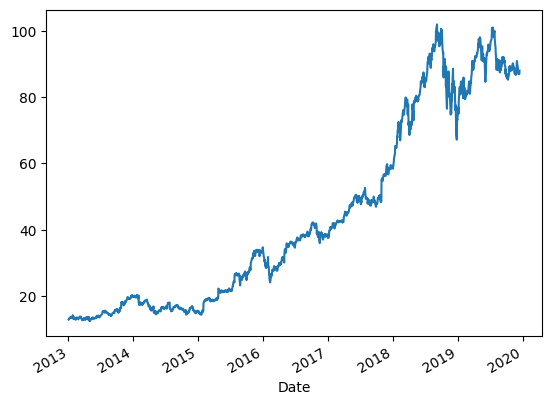

In [ ]:
all_data['Adj Close'].plot()

2. Modeling

In [ ]:
# LSTM과 GRU에서 활용하는 입출력 구조
'''
1) Many 2 Many
- producing an output for each input
- 과거 X일 동안의 데이터를 사용해서, 미래 Y일 동안의 데이터를 예측
  ex) window에 따라 5가지 시계열 입력값과 2개의 출력
- LSTM/GRU는 3차원 배열의 입력값을 사용하기 때문에 데이터를 3차원으로 재구성할 필요 있음
  A) samples : 데이터의 크기이며, 원본 데이터를 window size에 따라 슬라이싱 할 경우 생기는 데이터의 개수
  B) time steps: 과거 몇 개의 데이터를 볼 것인가를 나타내며, 네트워크에 사용할 시간 단위
  C) features: X의 변수 개수 (X의 차원)

2) Many 2 One
- producing an output for final input
- 과거 X일 동안의 데이터를 사용해서, 미래 1일의 데이터를 예측
- window size에 따라 (데이터가 0-6까지 있고, feature 5개, time step이 3이면)
  A) samples : 5 -> [0,1,2], [1,2,3], [2,3,4], [3,4,5], [4,5,6]
  B) time stpes : 3
  C) features : 5

즉, 3차원 입력데이터
X축 : 변수의 개수 (=features)
Y축 : 과거 며칠까지의 값을 반영하는가 (=time steps)
Z축 : 'features x time steps'의 형태로 원본 데이터를 재구성하면 몇 개의 sub-matirx가 나오는가 (=samples, data size)
'''

In [ ]:
def ts_train_test(all_data, time_steps, for_periods):
  '''
  input:
    data: 날짜를 인덱스로 가지는 주식가격(Adj Close) 데이터
  output:
    X_train, y_train: 2013-01-01부터 2018-12-31까지의 데이터
    X_test : 2019년 동안의 데이터
  time_steps: input 데이터의 time steps
  for_periods: output 데이터의 time steps
  '''

  # training & test set 만들기
  ts_train = all_data[:'2018'].iloc[:,0:1].values # iloc[행idx, 열idx] <- 여기서는 행 전부 & Date와 Adj Close열
  ts_test = all_data['2019':].iloc[:,0:1].values
  ts_train_len = len(ts_train)
  ts_test_len = len(ts_test)

  # 정규화
  from sklearn.preprocessing import MinMaxScaler
  sc = MinMaxScaler(feature_range = (0,1))
  ts_train_scaled = sc.fit_transform(ts_train)

  # training 데이터의 samples와 time steps로 원본 데이터 슬라이싱
  X_train = []
  y_train = []
  y_train_stacked = []
  for i in range(time_steps, ts_train_len - 1):
    X_train.append(ts_train_scaled[i-time_steps:i,0])
    y_train.append(ts_train_scaled[i:i+for_periods,0])
  X_train, y_train = np.array(X_train), np.array(y_train)

  # 3 차원으로 재구성
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

  # X_test 준비
  inputs = pd.concat((all_data["Adj Close"][:'2018'], all_data['Adj Close']['2019':]), axis = 0).values
  inputs = inputs[len(inputs) - len(ts_test) - time_steps:]
  inputs = inputs.reshape(-1,1)
  inputs = sc.transform(inputs)

  X_test = []
  for i in range(time_steps, ts_test_len + time_steps - for_periods):
    X_test.append(inputs[i-time_steps:i, 0])
  X_test = np.array(X_test)
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

  return X_train, y_train, X_test, sc

In [ ]:
# 5개의 time steps로 미래 2일 동안을 예측한다 하면 1505개의 샘플 생성
X_train, y_train, X_test, sc = ts_train_test(all_data, 5, 2)

# 3차원의 X_train을 df 형식으로 확인
X_train_see = pd.DataFrame(np.reshape(X_train, (X_train.shape[0], X_train.shape[1])))
y_train_see = pd.DataFrame(y_train)
print(pd.concat([X_train_see, y_train_see], axis = 1))

# 3차원의 X_test를 df 형식으로 확인
X_test_see = pd.DataFrame(np.reshape(X_test, (X_test.shape[0], X_test.shape[1])))
print(pd.DataFrame(X_test_see))


print("There are " + str(X_train.shape[0]) + " samples in the training data")
print('There are ' + str(X_test.shape[0]) + ' samples in the test data')


3. LSTM

In [ ]:
def LSTM_model(X_train, y_train, X_test, sc):
  from keras.models import Sequential
  from keras.layers import Dense, SimpleRNN, GRU, LSTM
  from keras.optimizers import SGD

  # Architecture
  LSTM_model = Sequential()   # 레이어를 선형으로 연결하여 구성
  LSTM_model.add(LSTM(
      units = 50,
      return_sequences = True,
      input_shape = (X_train.shape[1], 1),
      activation = 'tanh'
  ))
  LSTM_model.add(LSTM(units = 50, activation = 'tanh')) # 두 번째 이후 레이어들은 자동으로 형태를 추정할 수 있기에 형태 정보 X
  LSTM_model.add(Dense(units=2)) # 입력 뉴런과 출력 뉴런을 연결하는 전결합층

  # Compiling
  LSTM_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7,
                                     momentum = 0.9, nesterov = False),
                     loss = 'mean_squared_error')

  # train fitting
  LSTM_model.fit(X_train, y_train, epochs = 50, batch_size = 150, verbose = 0) # 에폭스 50이면 whole data를 50번 학습

  # test predicting
  LSTM_prediction = LSTM_model.predict(X_test)

  # 스케일러에 예측값 넣어 반환
  LSTM_prediction = sc.inverse_transform(LSTM_prediction)

  return LSTM_model, LSTM_prediction


In [ ]:
def actual_pred_plot(preds):
  actual_pred = pd.DataFrame(columns = ['Adj. Close', 'prediction'])
  actual_pred['Adj. Close'] = all_data.loc['2019':, 'Adj Close'][0:len(preds)]
  actual_pred['prediction'] = preds[:,0]

  from keras.metrics import MeanSquaredError
  m = MeanSquaredError()
  m.update_state(np.array(actual_pred['Adj. Close']), np.array(actual_pred['prediction']))

  return (m.result().numpy(), actual_pred.plot())

In [ ]:
my_LSTM_model, LSTM_prediction = LSTM_model(X_train, y_train, X_test, sc)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 1s 4ms/step


(6.8420277, <Axes: xlabel='Date'>)

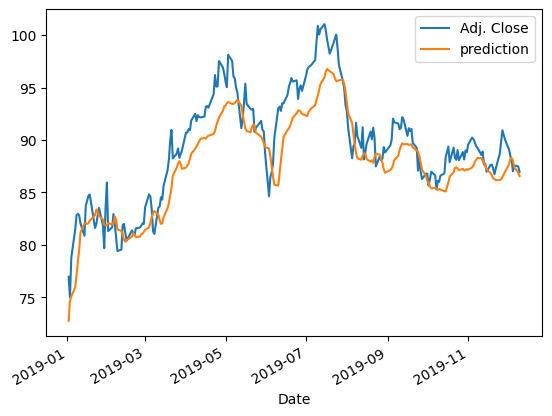

In [ ]:
actual_pred_plot(LSTM_prediction)

In [ ]:
y_pred = pd.DataFrame(LSTM_prediction[:,0])
y_test = all_data.loc['2019':, 'Adj Close'][0:len(LSTM_prediction)]
y_test.reset_index(drop = True, inplace = True)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

def confirm_result(y_test, y_pred):
  MAE = mean_absolute_error(y_test, y_pred)
  RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
  MSLE = mean_squared_log_error(y_test, y_pred)
  RMSLE = np.sqrt(mean_squared_log_error(y_test, y_pred))
  R2 = r2_score(y_test, y_pred)

  pd.options.display.float_format = '{:.5f}'.format
  Result = pd.DataFrame(data = [MAE, RMSE, RMSLE, R2],
                        index = ['MAE', 'RMSE', 'RMSLE', 'R2'],
                        columns = ['Results'])
  return Result

In [ ]:
confirm_result(y_test, y_pred)

,Results
MAE,2.13292
RMSE,2.61573
RMSLE,0.02880
R2,0.74485


4. GRU

In [ ]:
# GRU에는 cell state와 output gate가 없음
def GRU_model(X_train, y_train, X_test, sc):
  from keras.models import Sequential
  from keras.layers import Dense, SimpleRNN, GRU
  from keras.optimizers import SGD

  # Architecture
  GRU_model = Sequential()   # 레이어를 선형으로 연결하여 구성
  GRU_model.add(GRU(
      units = 50,
      return_sequences = True,
      input_shape = (X_train.shape[1], 1),
      activation = 'tanh'
  ))
  GRU_model.add(GRU(units = 50, activation = 'tanh')) # 두 번째 이후 레이어들은 자동으로 형태를 추정할 수 있기에 형태 정보 X
  GRU_model.add(Dense(units=2)) # 입력 뉴런과 출력 뉴런을 연결하는 전결합층

  # Compiling
  GRU_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7,
                                     momentum = 0.9, nesterov = False),
                     loss = 'mean_squared_error')

  # train fitting
  GRU_model.fit(X_train, y_train, epochs = 50, batch_size = 150, verbose = 0) # 에폭스 50이면 whole data를 50번 학습

  # test predicting
  GRU_prediction = GRU_model.predict(X_test)

  # 스케일러에 예측값 넣어 반환
  GRU_prediction = sc.inverse_transform(GRU_prediction)

  return GRU_model, GRU_prediction


In [ ]:
my_GRU_model, GRU_prediction = GRU_model(X_train, y_train, X_test, sc)
GRU_prediction[1:10]

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 1s 6ms/step


array([[74.98532 , 74.94015 ],
       [75.3421  , 75.29207 ],
       [76.3816  , 76.33195 ],
       [77.96591 , 77.91933 ],
       [79.64509 , 79.59931 ],
       [80.95473 , 80.906456],
       [82.056145, 81.99056 ],
       [82.365974, 82.28793 ],
       [82.037766, 81.95218 ]], dtype=float32)

(3.3101907, <Axes: xlabel='Date'>)

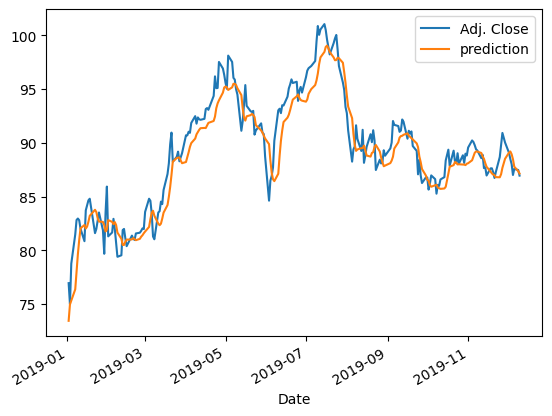

In [ ]:
actual_pred_plot(GRU_prediction)

In [ ]:
y_pred_gru = pd.DataFrame(GRU_prediction[:, 0])
y_test_gru = all_data.loc['2019':, 'Adj Close'][0:len(GRU_prediction)]
y_test_gru.reset_index(drop=True, inplace=True)

In [ ]:
confirm_result(y_test_gru, y_pred_gru)

,Results
MAE,1.42063
RMSE,1.81939
RMSLE,0.02032
R2,0.87656


In [ ]:
confirm_result(y_test, y_pred)

,Results
MAE,2.13292
RMSE,2.61573
RMSLE,0.02880
R2,0.74485
